In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from network_model import *
from neuron_model import *

def neuromod_slow_neg(neuron_number, scale_by, slow_neg_conductances):
    if type(neuron_number) == int:
        neuron_number = list(neuron_number)
        
    for elt in neuron_number:
        this_conductance = slow_neg_conductances[elt - 1]
        if this_conductance:
            old_a = this_conductance.a
            this_conductance.update_a(old_a * scale_by)
            print(f"Neuron #{elt} new a:", this_conductance.a)

In [23]:
# Make neurons
n_neurons = 5
neurons = [] # List neurons in network
slow_neg_conductances = [] # Keep track of slow neg conductances
def make_network():

    # Set timescales
    tf = 0.1
    ts = 20
    tsyn = ts
    tus = ts**2

    # Scale conductances
    # Slow HCO
    scl_s_slow = 1 # Scale slow pos&neg conductances in proportion to incrs intraburst freq.
    scl_us_slow = 0.5 # Scale ultraslow to increase interburst freq.

    # Fast HCO
    scl_s_fast = 2.5
    scl_us_fast = 8

    vmem_init = [-1, -3, 0, -1, -3] # Init vmems

    for i in range(n_neurons):
        
        # Set conductance scalars for fast, slow HCO
        if i < 2:
            scl_s = scl_s_slow
            scl_us = scl_us_slow
        elif i > 2:
            scl_s = scl_s_fast
            scl_us = scl_us_fast
            
        # First two neurons are slow HCO, 3rd is gap junction follower, last two are fast HCO
        if (i < 2) | (i > 2):
            neuron = Neuron(v0=vmem_init[i])

            R = neuron.add_conductance(1, E_rev = 0) # Add leak

            # Set gains and reversal potentials
            # Fast
            a_neg_f_init = -2
            voff_neg_f_init = 0

            # Slow
            a_pos_s_init = 2
            voff_pos_s_init = 0
            a_neg_s_init = -1.5
            voff_neg_s_init = -0.9

            # Ultra slow
            a_pos_us_init = 1.5
            voff_pos_us_init = -0.9

            # Add currents
            i1 = neuron.add_current(a_neg_f_init, voff_neg_f_init, tf)
            i2 = neuron.add_current(a_pos_s_init, voff_pos_s_init, ts, v0=vmem_init[i]-0.1)
            i3 = neuron.add_current(a_neg_s_init, voff_neg_s_init, ts, v0=vmem_init[i]-0.1)
            i4 = neuron.add_current(a_pos_us_init, voff_pos_us_init, tus, v0=vmem_init[i]-0.1)
        #     i5 = neuron.add_current(0, 0, tsyn, v0=vmem_init[i]-0.1) # Dummy current to simulate synapse
            
            # Scale condunctances to set rhythm pace
            i2.update_a(a_pos_s_init * scl_s)
            i3.update_a(a_neg_s_init * scl_s)
            i4.update_a(a_pos_us_init * scl_us)
            
            slow_neg_conductances.append(i3)
            
        else:
            neuron = Neuron(v0=vmem_init[i])
            R = neuron.add_conductance(1, E_rev = 0) # Add leak

            # Set gains and reversal potentials
            # Fast
            a_neg_f_init = -2
            voff_neg_f_init = 0

            # Slow
            a_pos_s_init = 2
            voff_pos_s_init = 0
            
            # Add currents
            i1 = neuron.add_current(a_neg_f_init, voff_neg_f_init, tf)
            i2 = neuron.add_current(a_pos_s_init, voff_pos_s_init, ts, v0=vmem_init[i]-0.1)
            
            slow_neg_conductances.append(None)
        
        neurons.append(neuron)
        

    # Make connections

    # Define the connectivity matrices; elt_ij is i => j
    g_inh = [[0, 0.2, 0.2, 0, 0],
            [0.2, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0.2],
            [0, 0, 0.2, 0.2, 0]] # inhibitory connection 
    # g_exc = [[0, 0, 0, 0, 0],
    #         [0, 0, 0, 0, 0],
    #         [0, 0, 0, 0, 0],
    #         [0, 0, 0, 0, 0],
    #         [0, 0, 0, 0, 0]] # excitatory connection
    g_res = [[0., 0., 0., 0., 0.],
            [0., 0., 0.2, 0, 0.],
            [0., 0.2, 0, 0.2, 0.],
            [0., 0., 0.2, 0., 0.],
            [0., 0., 0., 0., 0.]] # resistive connections

    voff = -1
    inh_synapse = CurrentSynapse(-1, voff, tsyn)
    exc_synapse = CurrentSynapse(+1, voff, tsyn)
    resistor = ResistorInterconnection()

    # Define the network
    # network = Network(neurons, (inh_synapse, g_inh), (exc_synapse, g_exc),
    #                 (resistor, g_res))
    network = Network(neurons, (inh_synapse, g_inh),
                    (resistor, g_res))
    return network

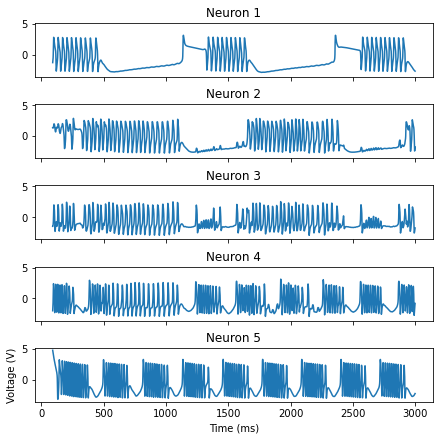

In [24]:
# Simulate STG
trange = (0, 3000) # time length of simulation
tfull = [] # Full simulation lists
yfull = []


# I applied
I01 = -0.78 # For neurons 1&2 (slow HCO)
I02 = -1.1 # For neurons 4&5 (fast HCO)
I03 = -1 # For neuron 3

i_app = lambda t: [I01, I01, I03, I02, I02]

temp = 15

for j in range(1):

    network = make_network() # Make net
    
    # Set y0 to last state
    if j > 0:
        network.y0 = list(sol.y[:,-1])
    
    for elt in network.neurons:
        elt.update_temp(temp)

    sol = network.simulate(trange, i_app)

    fig, ax = plt.subplots(n_neurons, 1, figsize=(6,6), sharex=True, sharey=True, constrained_layout=True)
    
    # Plot simulation
    tstart = 200 # Skip 50ms bc throws off the axes
    ax[0].plot(sol.t[tstart:], sol.y[0][tstart:], label="Neuron 1")
    ax[1].plot(sol.t[tstart:], sol.y[5][tstart:], label="Neuron 2")
    ax[2].plot(sol.t[tstart:], sol.y[10][tstart:], label="Neuron 3")
    ax[3].plot(sol.t[tstart:], sol.y[13][tstart:], label="Neuron 4")
    ax[4].plot(sol.t[tstart:], sol.y[18][tstart:], label="Neuron 5")

    # Label plot
    for i in range(n_neurons):
        ax[i].set_title(f"Neuron {i+1}")
    ax[4].set_ylabel("Voltage (V)")
    ax[4].set_xlabel("Time (ms)")

    # Save t, y
    tfull.append(sol.t)
    yfull.append(sol.y)
    plt.savefig(f"/home/stef/Nmc/Figures/stg_temp_perturb_{temp}C.png")
    plt.show()

In [10]:
print(network.get_init_conditions()) # 0, 5, 10, 13, 18
for elt in network.neurons:
    print(elt.timescales)

[-1.0, -1.8, -1.1, -1.1, -1.1, -3.0, -1.8, -3.1, -3.1, -3.1, 0.0, -1.8, -0.1, -1.0, -1.8, -1.1, -1.1, -1.1, -3.0, -1.8, -3.1, -3.1, -3.1]
[[0, 0], [-1, 0.17779126751127217], [1, 20.76322417625619], [-1, 35.352190697914686], [1, 650.1318940063983]]
[[0, 0], [-1, 0.17779126751127217], [1, 20.76322417625619], [-1, 35.352190697914686], [1, 650.1318940063983]]
[[0, 0], [-1, 0.17779126751127217], [1, 20.76322417625619]]
[[0, 0], [-1, 0.17779126751127217], [1, 20.76322417625619], [-1, 35.352190697914686], [1, 650.1318940063983]]
[[0, 0], [-1, 0.17779126751127217], [1, 20.76322417625619], [-1, 35.352190697914686], [1, 650.1318940063983]]
